## Peer-graded Assignment - Capstone - New location for *ChildrenAtHome*
#### Federica Stella

##### Importing Packages

In [1]:
#Installing the packages
get_ipython().system(u' pip install --upgrade pip')
get_ipython().system(u' pip install beautifulsoup4')
!pip install lxml
!pip install html5lib
!pip install requests

#Importing packages
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup

import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 1.5MB 8.5MB/s eta 0:00:01��███████████▊    | 1.3MB 8.5MB/s eta 0:00:01
  Found existing installation: pip 19.1.1
    Uninstalling pip-19.1.1:
      Successfully uninstalled pip-19.1.1
     |████████████████████████████████| 115 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 27.0 MB/s eta 0:00:01
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ---------------------------------

##### Reading from Wikipedia to get Toronto Neighborhoods

In [2]:
#Reading HTMl page 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response=requests.get(url)
html = response.text
page = BeautifulSoup(html,'html.parser')
#print(page)

#Getting table from the page that is saved in page1
wiki_table = page.body.table.tbody
#print(wiki_table)

# table = page.find_all('table')[0] # Grab the first table

# definition for getting cell
def get_cell(element):
    cells = element.find_all('td')
    row = []
    
    for cell in cells:
        if cell.a:            
            if (cell.a.text):
                row.append(cell.a.text)
                continue
        row.append(cell.string.strip())
        
    return row
#Definition for getting rows.
def get_row():    
    data = []  
    
    for tr in wiki_table.find_all('tr'):
        row = get_cell(tr)
        if len(row) != 3:
            continue
        data.append(row)        
    
    return data

##### Creating a Dataframe

In [3]:
rows = get_row()
columns_get = ['Postcode', 'Borough', 'Neighbourhood']
df = pd.DataFrame(rows, columns=columns_get)
df.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
df.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


##### Cleaning Data

In [4]:
df=df[df.Borough != 'Not assigned']
df = df.sort_values(by=['Postcode','Borough'])
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)
df_post = df['Postcode']
df_post.drop_duplicates(inplace=True)
#df_post
df_new = pd.DataFrame(df_post)
df_new['Borough'] = '';
df_new['Neighbourhood'] = '';

df_new.reset_index(inplace=True)
df_new.drop('index', axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


##### Read Coordinates of neighborhoods from Coursera Database

In [5]:
ll_dt=pd.read_csv("http://cocl.us/Geospatial_data")
ll_dt.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
ll_dt.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


##### Merge Dataframes

In [6]:
df_final=pd.merge(df,ll_dt,how='left',on='Postcode')
df_final.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


##### Create a map of Toronto with Folium

In [7]:
# create map of Toronto
latitude=43.653908
longitude=-79.384293
map_to = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=blue,
        fill=True,
        #fill_color=blue,
        fill_opacity=0.7).add_to(map_to)
map_to

##### Define Forsquare credentials and version

In [8]:
CLIENT_ID = 'H3H2BZ5RVOR2KMHZ1AVCWZDS0SO03EGOF525YGV5L043DGWB' # your Foursquare ID
CLIENT_SECRET = 'CUIKATCYI111X14DMQTRKTMLTVATFEOPL4OHUBRAY1U51IBP' # your Foursquare Secret
VERSION = '20180604'

In [9]:
venues_table.drop(inplace=True)
venues_table

NameError: name 'venues_table' is not defined

##### Search schools

In [ ]:
LIMIT=10000
radius=5000
categoryId='4f4533804b9074f6e4fb0105'
url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            categoryId,        
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION,
            radius,
            LIMIT
            )
# assign relevant part of JSON to venues
results = requests.get(url).json()
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories','location.lat','location.lng']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
dataframe_filtered['Neighborhood']='Neighborhood Name'

dataframe_filtered.head()

In [41]:
df_final

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


##### Identify Schools per neighborhoods

In [60]:
LIMIT=100
radius=1000
#venues_table.drop(inplace=True)
venues_table = pd.DataFrame(index=range(1,5))
venues_table = pd.DataFrame(columns=['name','categories','lat','lng','Neighborhood'])
categoryId='4f4533804b9074f6e4fb0105,4bf58dd8d48988d13d941735,4f4533814b9074f6e4fb0106,52e81612bcbc57f1066b7a45,4f4533814b9074f6e4fb0107'


for name, latitude, longitude in zip(df_final.Neighborhood, df_final.Latitude, df_final.Longitude):
    # assign relevant part of JSON to venues
    print(name,latitude, longitude)
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            categoryId,        
            CLIENT_ID, 
            CLIENT_SECRET, 
            latitude, 
            longitude, 
            VERSION,
            radius,
            LIMIT
            )
    results = requests.get(url).json()
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    dataframe.head()
    if dataframe.shape[0] > 0 :
        # keep only columns that include venue name, and anything that is associated with location
        filtered_columns = ['name', 'categories','location.lat','location.lng']
        dataframe_filtered = dataframe.loc[:, filtered_columns]

        # function that extracts the category of the venue
        def get_category_type(row):
            try:
                categories_list = row['categories']
            except:
                categories_list = row['venue.categories']

            if len(categories_list) == 0:
                return None
            else:
                return categories_list[0]['name']

        # filter the category for each row
        dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

        # clean column names by keeping only last term
        dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
        dataframe_filtered['Neighborhood']=name
        venues_table=venues_table.append(dataframe_filtered)
    
    
    
venues_table.head()


Malvern, Rouge 43.806686299999996 -79.19435340000001


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Rouge Hill, Port Union, Highland Creek 43.7845351 -79.16049709999999
Guildwood, Morningside, West Hill 43.7635726 -79.1887115
Woburn 43.7709921 -79.21691740000001
Cedarbrae 43.773136 -79.23947609999999
Scarborough Village 43.7447342 -79.23947609999999
Kennedy Park, Ionview, East Birchmount Park 43.7279292 -79.26202940000002
Golden Mile, Clairlea, Oakridge 43.711111700000004 -79.2845772
Cliffside, Cliffcrest, Scarborough Village West 43.716316 -79.23947609999999
Birch Cliff, Cliffside West 43.692657000000004 -79.2648481
Dorset Park, Wexford Heights, Scarborough Town Centre 43.7574096 -79.27330400000001
Wexford, Maryvale 43.750071500000004 -79.2958491
Agincourt 43.7942003 -79.26202940000002
Clarks Corners, Tam O'Shanter, Sullivan 43.7816375 -79.3043021
Milliken, Agincourt North, Steeles East, L'Amoreaux East 43.8152522 -79.2845772
Steeles West, L'Amoreaux West 43.799525200000005 -79.3183887
Upper Rouge 43.836124700000006 -79.20563609999999
Hillcrest Village 43.8037622 -79.3634517
Fairvie

,name,categories,lat,lng,Neighborhood
0,Alvin Curling Public School,Elementary School,43.808683,-79.190103,"Malvern, Rouge"
1,St Columba Catholic School,Elementary School,43.803955,-79.207889,"Malvern, Rouge"
0,Centennial Public School,Elementary School,43.787445,-79.147205,"Rouge Hill, Port Union, Highland Creek"
0,Eastview Junior Public School,Elementary School,43.759141,-79.190444,"Guildwood, Morningside, West Hill"
1,Galloway Road Public School,Elementary School,43.764834,-79.196306,"Guildwood, Morningside, West Hill"


##### Show categories

In [61]:
venues_table.groupby("categories")["name"].count()

categories
Elementary School    190
Event Space            2
High School          252
Middle School         43
Non-Profit            10
Nursery School        60
Preschool              2
Private School         5
School                16
Trade School           1
Name: name, dtype: int64

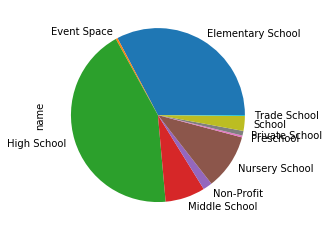

In [62]:
venues_table.name.groupby(venues_table.categories).count().plot(kind='pie')

In [71]:
#venues_table.groupby("Neighborhood")["name"].count().apply()
grouped = venues_table.groupby('Neighborhood', sort=False).count()
grouped.sort_values('name',ascending=False, inplace=True)
grouped.head(10)


,name,categories,lat,lng
Neighborhood,,,,
Central Bay Street,18,18,18,18
"Richmond, Adelaide, King",18,18,18,18
"University of Toronto, Harbord",16,16,16,16
"Queen's Park, Ontario Provincial Government",16,16,16,16
"North Toronto West, Lawrence Park",15,15,15,15
"Garden District, Ryerson",15,15,15,15
"First Canadian Place, Underground city",15,15,15,15
Downsview,15,15,15,15
Church and Wellesley,14,14,14,14


##### average coordinates for schools

In [75]:
venues_table.mean()

lat    43.689417
lng   -79.392317
dtype: float64

##### Dispaymap of schools

In [79]:
# create map of Toronto
latitude=43.653908
longitude=-79.384293
map_to = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi in zip(venues_table['lat'], venues_table['lng'], venues_table['name']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_to)

    
# add mean coordinates    
folium.CircleMarker(
    [43.689417, -79.384293],
    radius=10,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7).add_to(map_to)    
    
map_to

#### Show just top 5 neighborhoods and mean

In [93]:
#grouped.reset_index(inplace=True)
top_ten=grouped[['Neighborhood','name']].head(5)
top_ten_final=pd.merge(top_ten,venues_table,how='left',on='Neighborhood')
top_ten_final

,Neighborhood,name_x,name_y,categories,lat,lng
0,Central Bay Street,18,St Josephs College Secondary School,High School,43.664259,-79.388681
1,Central Bay Street,18,l'École nationale de ballet du Canada,High School,43.664839,-79.379457
2,Central Bay Street,18,Ryerson Public School,Elementary School,43.651401,-79.402255
3,Central Bay Street,18,Church Street Junior Public School,High School,43.663483,-79.379778
4,Central Bay Street,18,Collège Français,High School,43.662552,-79.377681
5,Central Bay Street,18,Blyth Academy,High School,43.668375,-79.386737
6,Central Bay Street,18,Lord Lansdowne Public School,Elementary School,43.658731,-79.402031
7,Central Bay Street,18,Heydon Park school,High School,43.655171,-79.394681
8,Central Bay Street,18,Contact Alternative School,High School,43.654132,-79.390083
9,Central Bay Street,18,Keystone International School,High School,43.650620,-79.376154


In [95]:
top_ten_final.mean()

name_x    16.686747
lat       43.668629
lng      -79.392899
dtype: float64

In [96]:
# create map of Toronto
latitude=43.653908
longitude=-79.384293
map_to = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
for lat, lon, poi in zip(top_ten_final['lat'], top_ten_final['lng'], top_ten_final['name_y']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(map_to)

    
# add mean coordinates    
folium.CircleMarker(
    [43.668629, -79.392899],
    radius=10,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7).add_to(map_to)    
    
map_to